# Patch Phenotyping Tutorial

This notebook demonstrates how to perform patch phenotyping using pre-trained KRONOS embeddings. The workflow involves extracting patch embeddings from multiplex images and classifying patch phenotypes. Below, we outline the required inputs and provide a step-by-step guide to the process.

## Prerequisites

To follow this tutorial, ensure you have the following data prepared:

1. **Multiplex Images**: TIFF images with multiple markers (e.g., DAPI, CD markers, etc.).
2. **Marker Metadata**: A CSV file containing the following columns:
    - `channel_id`: Identifier for the image channel.
    - `marker_name`: Name of the marker (e.g., DAPI, CD20).
    - `marker_id`: Unique ID for the marker.
    - `marker_mean`: Mean intensity value for normalization.
    - `marker_std`: Standard deviation for normalization.
3. **Cell Masks**: Grayscale images where:
    - Each cell pixel is represented by a unique cell ID.
    - Non-cell pixels are represented by `0`.
4. **Ground Truth Annotations**: A CSV file with the following columns:
    - `image_name`: Name of the multiplex image.
    - `cell_id`: Unique ID of the cell in the cell mask.
    - `x_center`: X-coordinate of the cell center.
    - `y_center`: Y-coordinate of the cell center.
    - `cell_type_id`: Phenotype label of the cell.

**Notes**:<br> 
Refer to the **[How-to-get-marker-metadata-file](https://github.com/mahmoodlab/KRONOS/blob/main/tutorials/1%20-%20How-to-get-marker-metadat-file.ipynb)** tutorial to generate the metadata file for your dataset. <br>
Note: cHL dataset does not have patch phenotype labels therefore, we will generate patch phenotype lables using cell level labels with majority vote.  


## Overview

This tutorial performs **patch-based phenotyping**, which involves the following steps:

1. **Patch Extraction**: Extract patches from multiplex images using sliding window approach.
2. **Feature Extraction**: Use the pre-trained KRONOS model to extract feature embeddings for each patch.
3. **Classification**: Train a logistic regression model to classify patch phenotypes based on the extracted features.
4. **Evaluation**: Evaluate the model using cross-validation and compute metrics such as F1-Score, Balanced Accuracy, and ROC AUC.

By the end of this tutorial, you will have a complete pipeline for patch phenotyping using KRONOS features.

## Step 1: Import Required Packages

We begin by importing the necessary libraries and modules for the workflow.

In [1]:
from utils import PatchPhenotyping 

## Step 2: Experiment Configuration

In this section, we define the configuration and hyperparameters required for the workflow. Ensure your dataset in the project directory is organized as follows:

### Dataset Structure
- **`dataset/multiplex_images/`**: Contains the multiplex image files (e.g., `.tiff`).
- **`dataset/cell_masks/`**: Contains the cell mask files corresponding to the multiplex images.
- **`dataset/marker_info_with_metadata.csv`**: A CSV file containing marker metadata.
- **`dataset/cell_annotations.csv`**: A CSV file containing ground truth annotations.

### Output Directories
The following directories in the project directory will be generated during the workflow:
- **`patches/`**: Stores the extracted cell-centered patches in `.h5` format.
- **`features/`**: Stores the extracted features in `.npy` format.
- **`folds/`**: Contains cross-validation folds for training, validation, and testing.
- **`results/`**: Stores the results for each fold and aggregated metrics.

In [ ]:
# Define the root directory for the project
project_dir = "/path/to/project/directory/"  # Replace with your actual root directory

# Configuration dictionary containing all parameters for the pipeline
config = {
    # Dataset-related parameters, feel free to modify these paths according to your dataset structure
    "image_dir_path": f"{project_dir}/dataset/multiplex_images/",  # Path to the multiplex image file
    "cell_mask_dir_path": f"{project_dir}/dataset/cell_masks/",  # Path to the cell mask file
    "marker_info_with_metadata_csv_path": f"{project_dir}/dataset/marker_info_with_metadata.csv",  # Path to the marker metadata CSV file
    "gt_csv_path": f"{project_dir}/dataset/cell_annotations.csv",  # Path to the ground truth annotations CSV file
    "num_classes": 16,  # Number of cell types in the dataset
    
    # Output directories for intermediate and final results
    "patch_dir": f"{project_dir}/patches/",  # Directory to save extracted patches
    "feature_dir": f"{project_dir}/features/",  # Directory to save extracted features
    "fold_dir": f"{project_dir}/folds/",  # Directory to save cross-validation folds
    "result_dir": f"{project_dir}/results/",  # Directory to save final results
    
    # Model-related parameters
    "checkpoint_path": "hf_hub:MahmoodLab/kronos",  # Path to the pre-trained model checkpoint (local or Hugging Face Hub)
    "hf_auth_token": None,  # Authentication token for Hugging Face Hub (if checkpoint is from the Hugging Face Hub)
    "cache_dir": f"{project_dir}/models/",  # Directory to cache KRONOS model if downloading model from Hugging Face Hub
    "model_type": "vits16",  # Type of pre-trained model to use (e.g., vits16)
    "token_overlap": True,  # Whether to use token overlap during feature extraction

    # Patch extraction parameters
    "patch_size": 32,  # Size of the patches to extract (e.g., 64x64 pixels)
    "patch_stride": 16,  # Stride for patch extraction (e.g., 32 pixels)
    "token_size": 16,  # Size of the tokens for the model (e.g., 16x16 pixels)
    "token_stride": 8,  # Stride for token extraction (e.g., 16 or 8 pixels)

    # Feature extraction parameters
    "marker_list": ['DAPI', 'CD11B', 'CD11C', 'CD15', 'CD163', 'CD20', 'CD206', 'CD30', 'CD31', 'CD4', 'CD56', 'CD68', 'CD7', 'CD8', 'CYTOKERATIN', 'FOXP3', 'MCT', 'PODOPLANIN'],  # List of markers to process
    "marker_max_values": 65535.0,  # Maximum possible value marker image, depends on image type (e.g., 255 for uint8, 65535 for uint16)
    "patch_batch_size": 16,  # Batch size for patch-based data loading
    "num_workers": 4,  # Number of workers for data loading

    # Logistic regression parameters
    "max_patches_per_type": 1000,  # Maximum number of patches per phenotype for training, set to None for no limit
    "feature_batch_size": 256,  # Batch size for feature-based data loading
    "n_trials": 25,  # Number of trials for Optuna hyperparameter optimization
    "C_low": 1e-10,  # Lower bound for the regularization parameter (C) in logistic regression
    "C_high": 1e5,  # Upper bound for the regularization parameter (C) in logistic regression
    "max_iter": 10000,  # Maximum number of iterations for logistic regression training
}
obj = PatchPhenotyping(config)

## Step 3: Patch Extraction

Extract patches from multiplex images using cell masks and annotations. Each patch is stored in an HDF5 (`.h5`) file with the following structure:
                - A cell segmentation mask under the key "cell_seg_map".
                - A cell type map under the key "cell_type_map".
                - Individual marker datasets for each marker in the patch.
- **Cell segmentation map**: Stored under the key `cell_seg_map`, where each non-zero pixel represent cell id and 0 represents the non-cell region.
- **Cell type map**: Stored under the key `cell_type_map`, where each non-zero pixel represent cell type and 0 represents the non-cell region.
- **Marker datasets**: Each marker dataset contains intensity values corresponding to a specific marker within the patch.

**File Naming Convention**: `{image_name}_{x}_{y}.h5`  
Example: `"image_01_000000_000032.h5"` represents patch who top-left corner is at [0,32] in the image `"image_01.tiff"`.

In [ ]:
obj.patch_extraction()

## Step 4: Feature Extraction

Extract features from patches using a pre-trained model. This step processes patches of multiplex images, applies a pre-trained model to extract meaningful feature vectors, and saves them for downstream analysis.

In [ ]:
obj.feature_extraction()

## Step 5: Generate Data Folds

Generate data folds for training, validation, and testing. This tutorial uses a cHL dataset, dividing a large visual field into four quadrants. Each quadrant represents one fold.

In [ ]:
obj.folds_generation()

## Step 6: Train Cell Phenotyping Model

Train a logistic regression model on the training data, validate it on the validation data, and evaluate it on the test data. Results for each fold are saved in the output directory.

In [ ]:
obj.train_classification_model()

## Step 7: Evaluate Model

Read the test results for each fold, compute evaluation metrics (F1-Score, Balanced Accuracy, Average Precision, and ROC AUC), and calculate the average and standard deviation across all folds.

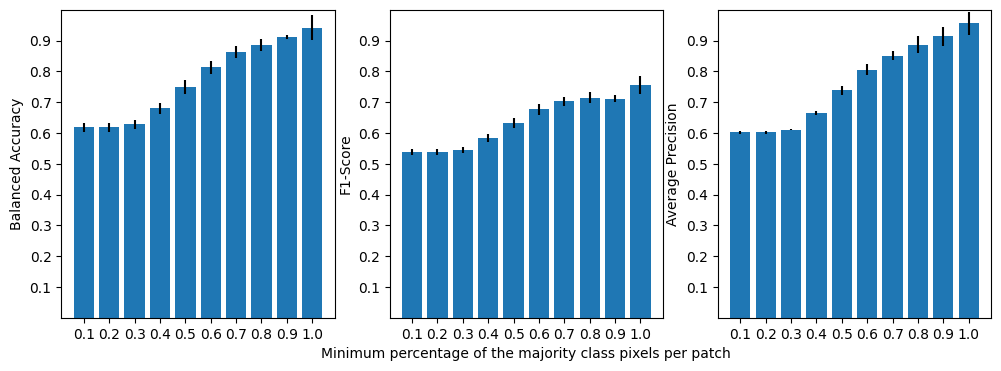

In [7]:
obj.eval_classification_model()
obj.calculate_results()
obj.plot_results()

## Step 8: Visual Results

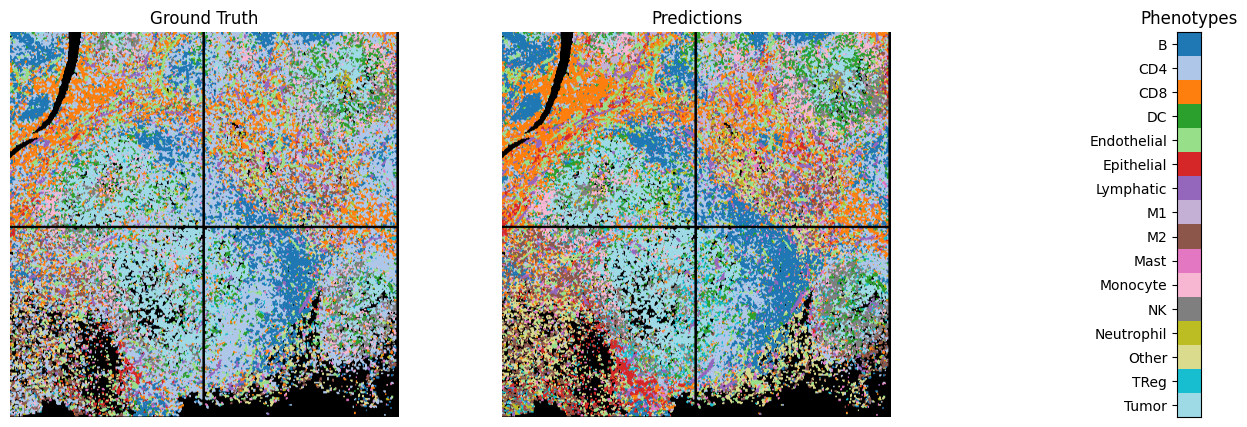

In [8]:
obj.visual_results()